In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import joblib


In [2]:
df = pd.read_csv(r"C:\Users\User\Desktop\ProjectSkies\project\ObesityDataSet_raw_and_data_sinthetic.csv")

In [3]:
df.head()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [5]:
df.describe()


,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [6]:
#Checking for null values
df.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [7]:
#Checking for data types
df.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

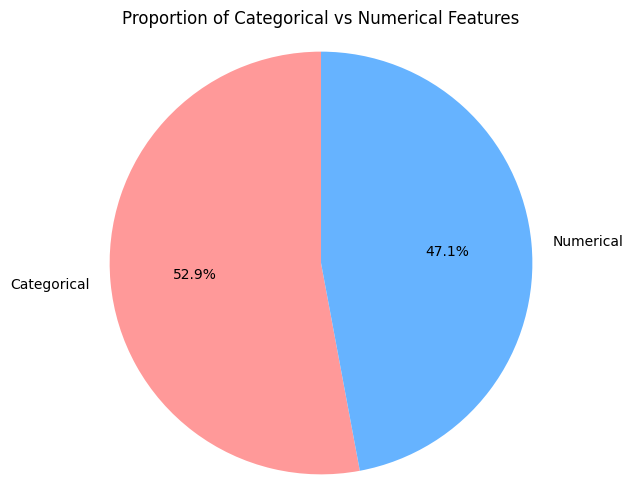

In [8]:
# Get data types
feature_types = df.dtypes

# Classify each column as Categorical or Numerical
type_labels = feature_types.apply(lambda x: 'Categorical' if x == 'object' else 'Numerical')

# Count how many are categorical vs numerical
counts = type_labels.value_counts()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90)
plt.title('Proportion of Categorical vs Numerical Features')
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle.
plt.savefig("feature_types_pie.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
df['NObeyesdad'].unique()

array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

In [10]:
df['NObeyesdad'].value_counts()

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

**Feature Engineering**

**Adding BMI Collumn**

NObesity Target Column:¶

Underweight Less than 18.5

Normal 18.5 to 24.9

Overweight 25.0 to 29.9

Obesity I 30.0 to 34.9

Obesity II 35.0 to 39.9

Obesity III Higher than 40

In [11]:
df['BMI'] = df['Weight'] / (df['Height'] ** 2)


In [12]:
df.columns


Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad', 'BMI'],
      dtype='object')

In [13]:
df.shape

(2111, 18)

In [14]:
df['BMI'].dtype


dtype('float64')

In [15]:
df['BMI'].unique()

array([24.38652644, 24.23822715, 23.7654321 , ..., 43.54381658,
       44.0715354 , 44.14433794])

**Countplots for categorical collums**

In [16]:
cat_cols = df[['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']]

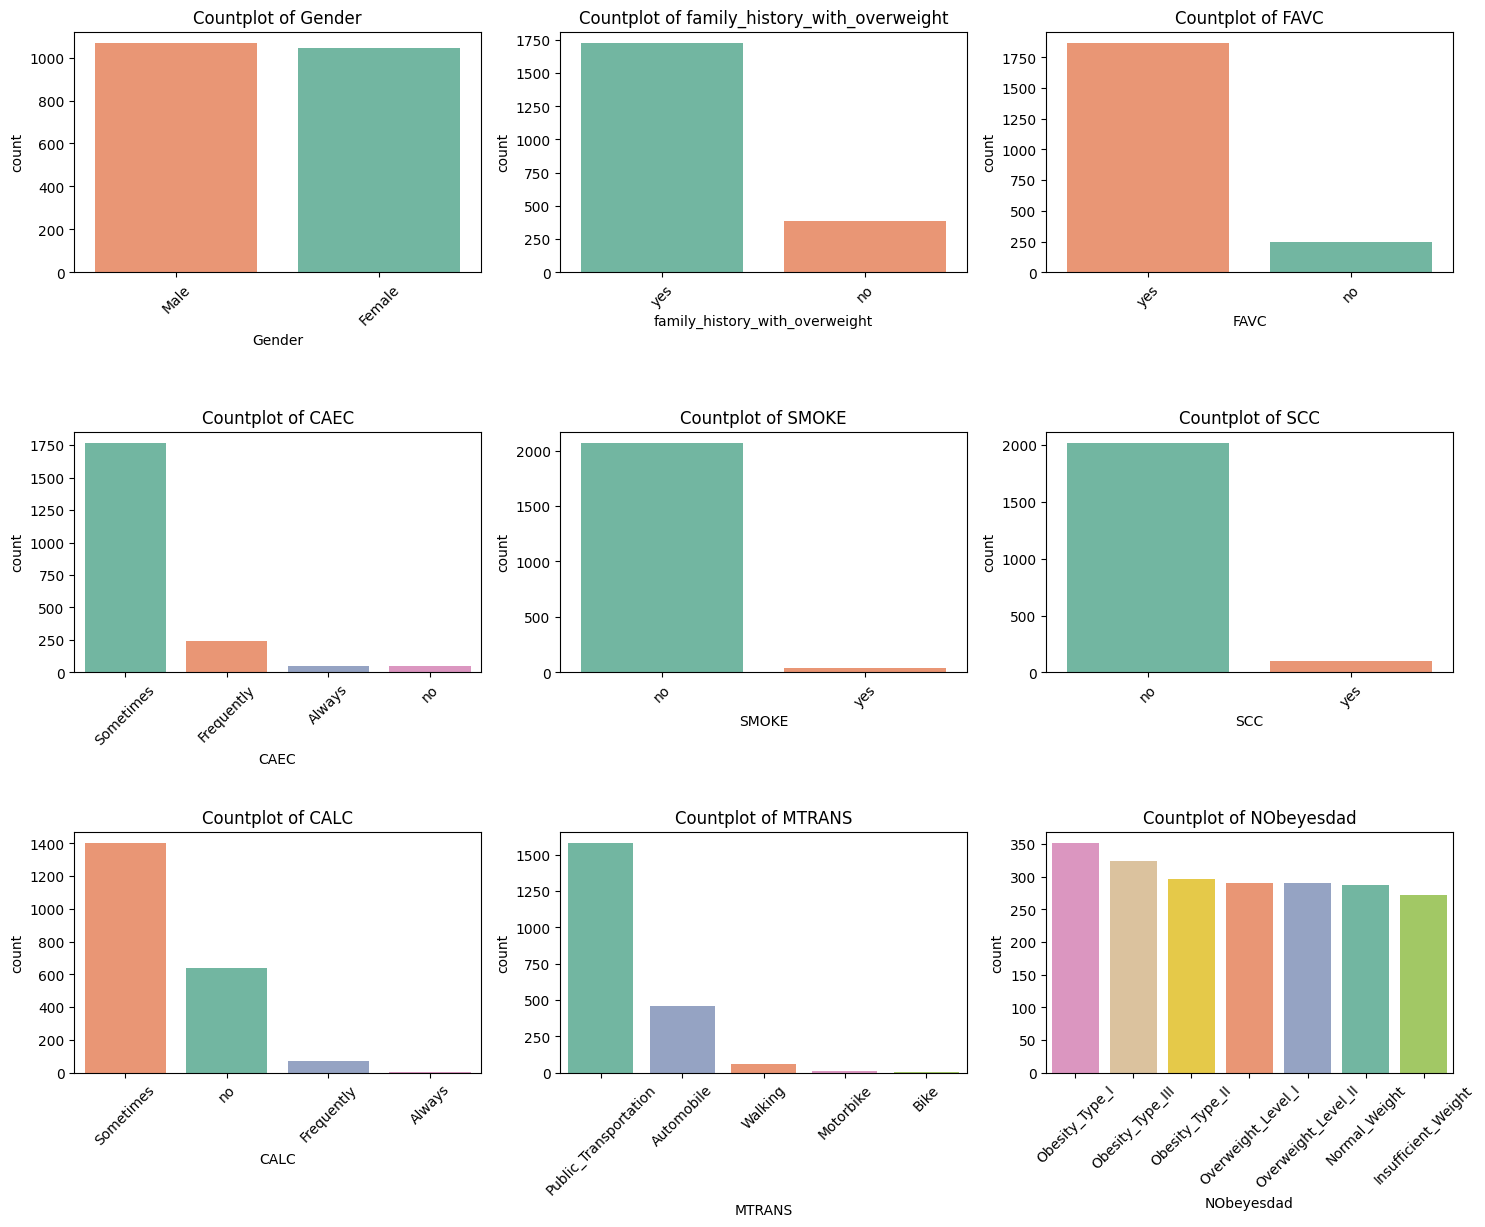

In [17]:
# Assuming cat_cols is your list of categorical column names
n = len(cat_cols)                  # Number of plots
cols = 3                           # Number of plots per row
rows = math.ceil(n / cols)        # Compute number of rows needed

plt.figure(figsize=(5 * cols, 4 * rows))  # Adjust size as needed

for i, col in enumerate(cat_cols, 1):
    plt.subplot(rows, cols, i)
    sns.countplot(data=df, x=col, hue= col, palette='Set2', order=df[col].value_counts().index)
    plt.title(f"Countplot of {col}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("categorical_countplots.png", dpi=300, bbox_inches='tight')
plt.show()



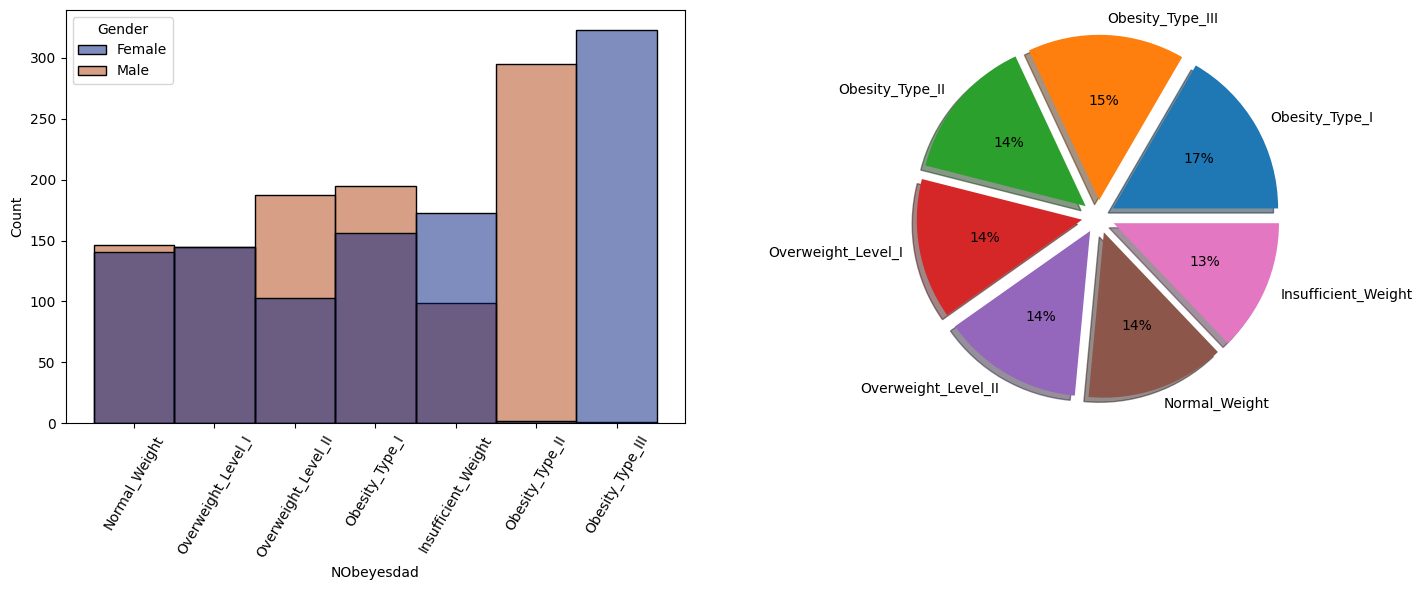

In [18]:

cat = 'NObeyesdad'  # or whichever categorical column you want

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Histogram with hue by Gender
sns.histplot(binwidth=0.5, x=cat, data=df, hue='Gender', palette="dark", ax=axs[0], discrete=True)
axs[0].tick_params(axis='x', rotation=60)
plt.savefig("target_gendercountplots.png", dpi=300, bbox_inches='tight')
# Pie chart using df[cat]
axs[1].pie(
    df[cat].value_counts(),
    shadow=True,
    explode=[.1 for _ in range(df[cat].nunique())],
    labels=df[cat].value_counts().index,
    autopct='%1.f%%',
)

plt.tight_layout()
plt.show()


**Visualizations for the numerical collumns**

**Countplots**

In [19]:
num_cols = df[['Age', 'Height', 'Weight','FCVC', 'NCP','CH2O', 'FAF', 'TUE', 'BMI']]

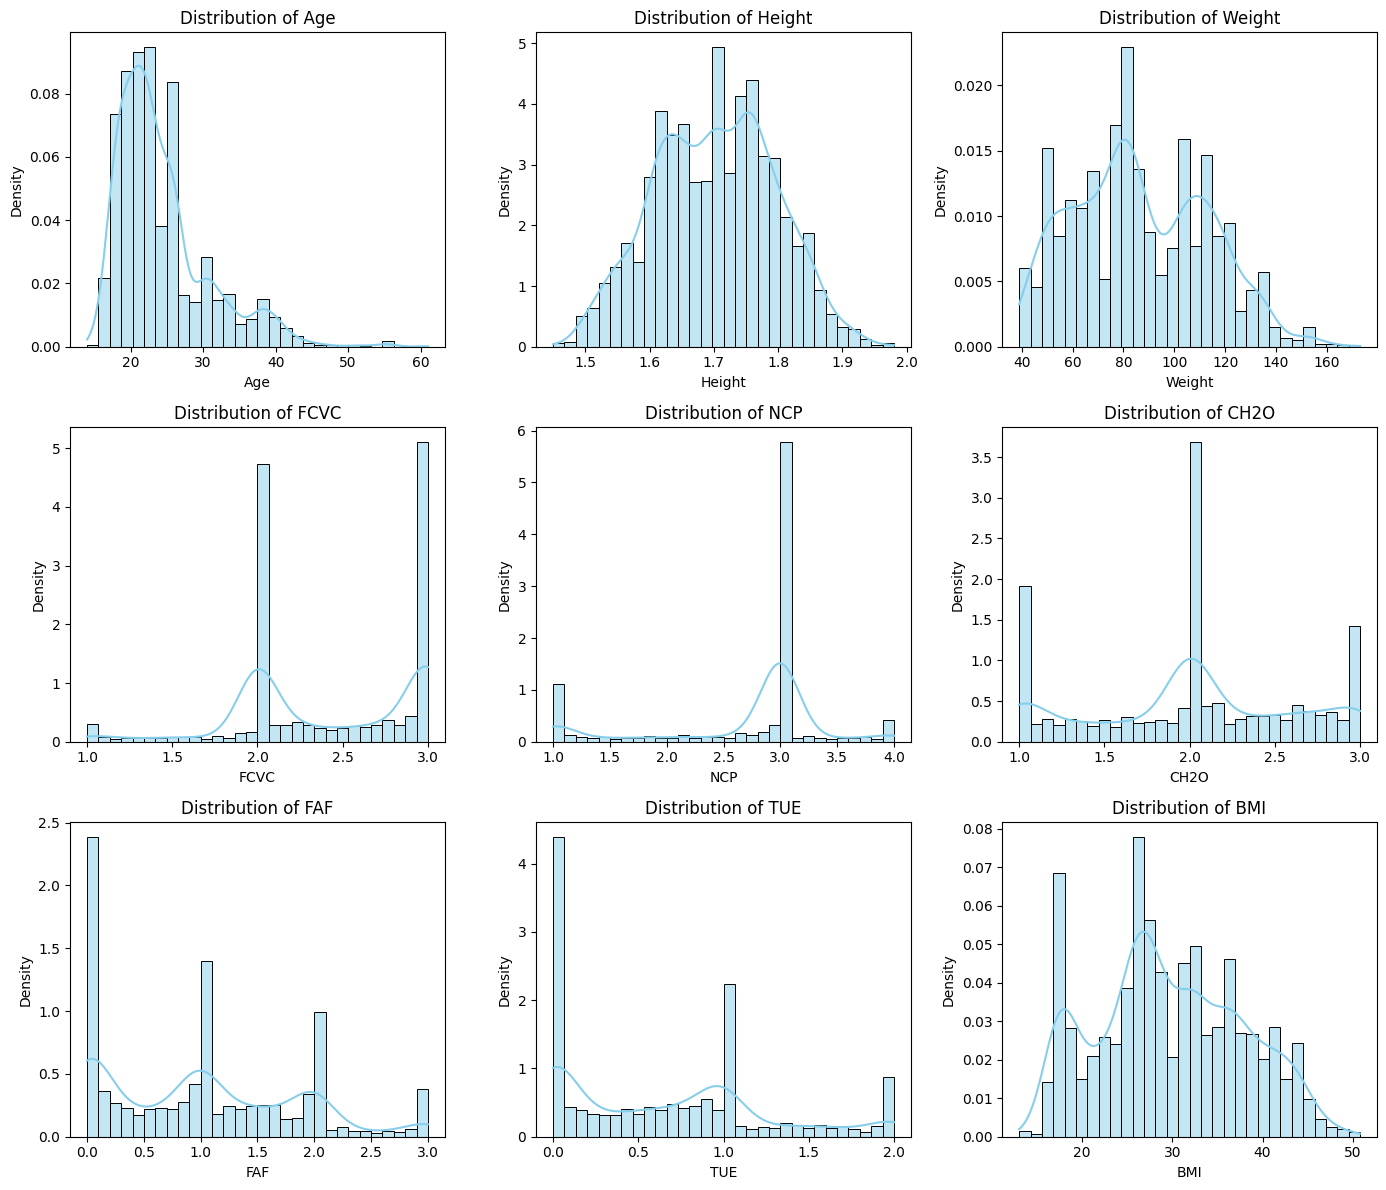

In [20]:
# Set up the plot size
plt.figure(figsize=(14, 12))

# Loop through the numerical columns and create a histogram for each
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)  # Adjust the grid size based on the number of features
    sns.histplot(df[col], kde=True, bins=30, color="skyblue", stat="density")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()  # To adjust the layout so plots don't overlap
plt.show()

import plotly.express as px

fig = px.sunburst(
    df,  # your DataFrame
    path=['NObeyesdad','Gender','MTRANS','family_history_with_overweight','SMOKE'],  # hierarchy order
    color='Gender',  # sets colors by 'Gender'
    color_discrete_map={'Male':'gold', 'Female':'darkblue'},  # manually assign colors
    width=1200, height=1200  # chart size
)

fig.show()


**Findings:**
Obesity level II was specific to males while obesity level III was specific to females.

In [21]:
df['NCP'].unique()

array([3.      , 1.      , 4.      , 3.28926 , 3.995147, 1.72626 ,
       2.581015, 1.600812, 1.73762 , 1.10548 , 2.0846  , 1.894384,
       2.857787, 3.765526, 3.285167, 3.691226, 3.156153, 1.07976 ,
       3.559841, 3.891994, 3.240578, 3.904858, 3.11158 , 3.590039,
       2.057935, 3.558637, 2.000986, 3.821168, 3.897078, 3.092116,
       3.286431, 3.592415, 3.754599, 3.566082, 3.725797, 3.520555,
       3.731212, 1.259803, 1.273128, 3.304123, 3.647154, 3.300666,
       3.535016, 1.717608, 2.884479, 3.626815, 1.473088, 3.16645 ,
       3.494849, 2.99321 , 2.127797, 3.90779 , 3.699594, 3.179995,
       1.075553, 3.238258, 3.804944, 1.630846, 3.762778, 3.371832,
       2.705445, 3.34175 , 2.217651, 2.893778, 3.502604, 3.998766,
       3.193671, 1.69608 , 2.812377, 1.612747, 1.082304, 1.882158,
       2.326233, 1.989398, 1.735493, 2.974568, 3.715118, 3.489918,
       3.378859, 3.263201, 3.994588, 3.24934 , 3.087544, 1.163666,
       3.409363, 3.281391, 3.98525 , 3.207071, 3.471536, 3.488

**Boxplots for the Numerical ColumnS**

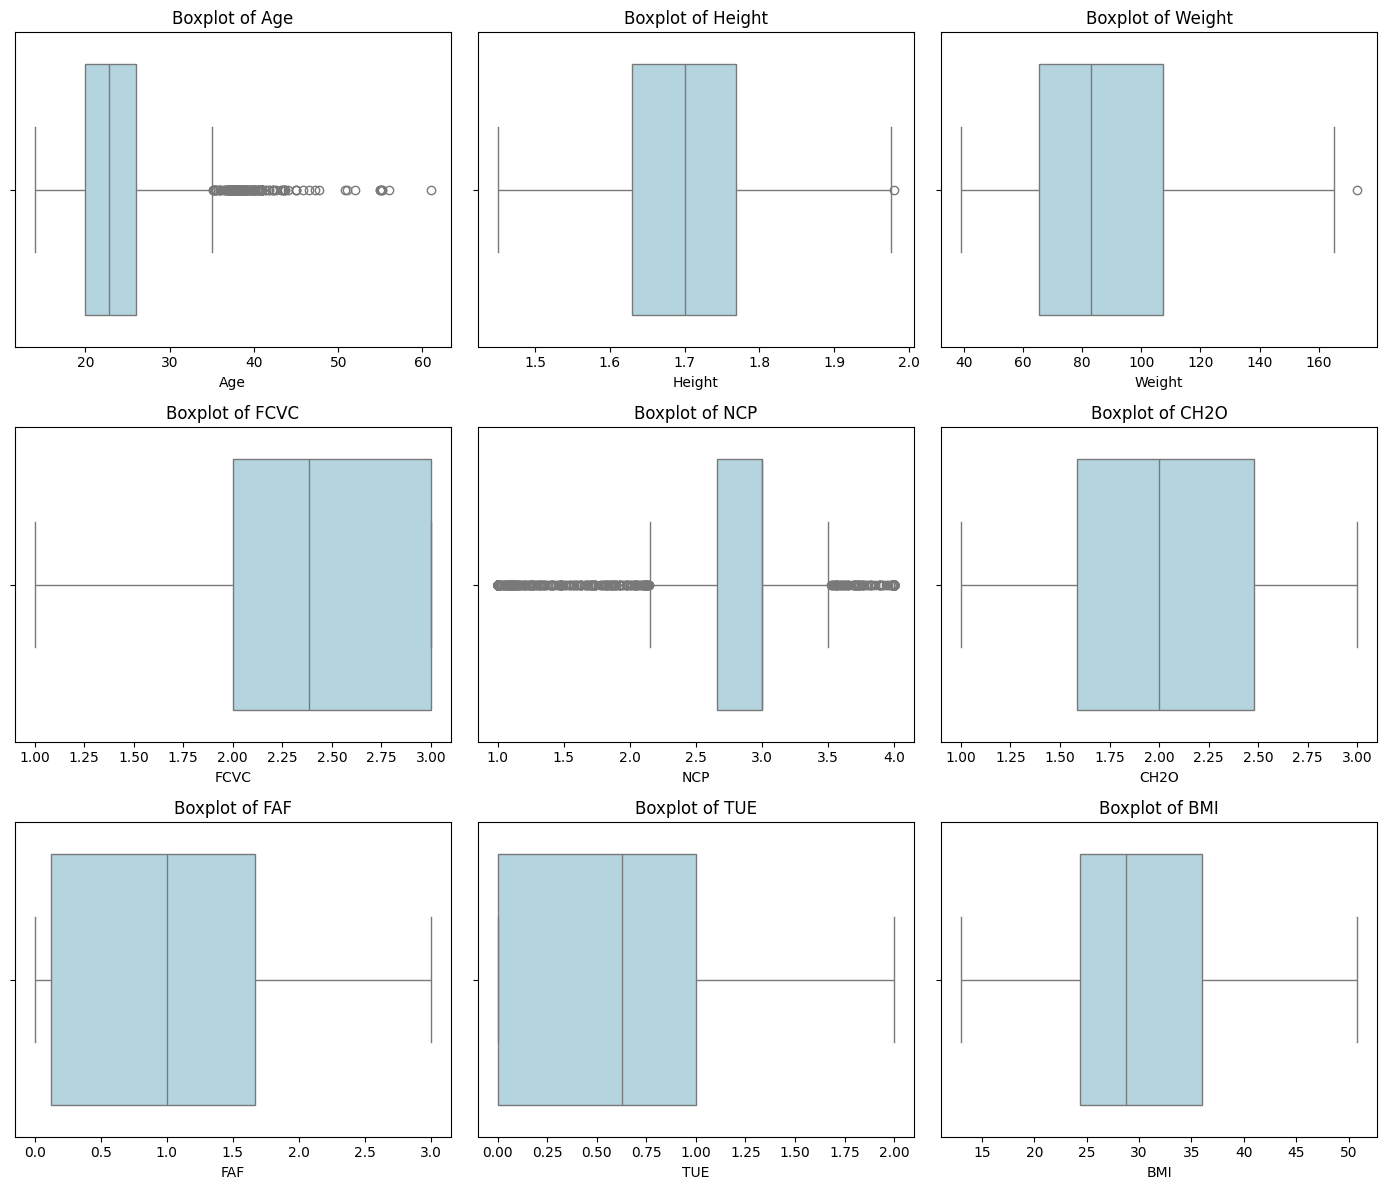

In [22]:
#boxplot of the numerical features
# Set up the plot size
plt.figure(figsize=(14, 12))

# Loop through the numerical columns and create a boxplot for each
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)  # Adjust the grid size based on the number of features
    sns.boxplot(x=df[col], color="lightblue")
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)

plt.tight_layout()  # To adjust the layout so plots don't overlap
plt.savefig("numerical_boxplots.png", dpi=300, bbox_inches='tight')
plt.show()


In [23]:
import pandas as pd

# Create a dictionary to store outliers for each column
outliers_dict = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_dict[col] = outliers

    print(f"{col}: {len(outliers)} outliers")

# If you want to view the outliers for a specific column, say 'Age':
# print(outliers_dict['Age'])


Age: 168 outliers
Height: 1 outliers
Weight: 1 outliers
FCVC: 0 outliers
NCP: 579 outliers
CH2O: 0 outliers
FAF: 0 outliers
TUE: 0 outliers
BMI: 0 outliers


**Correlation heatmap for the numerical columns**

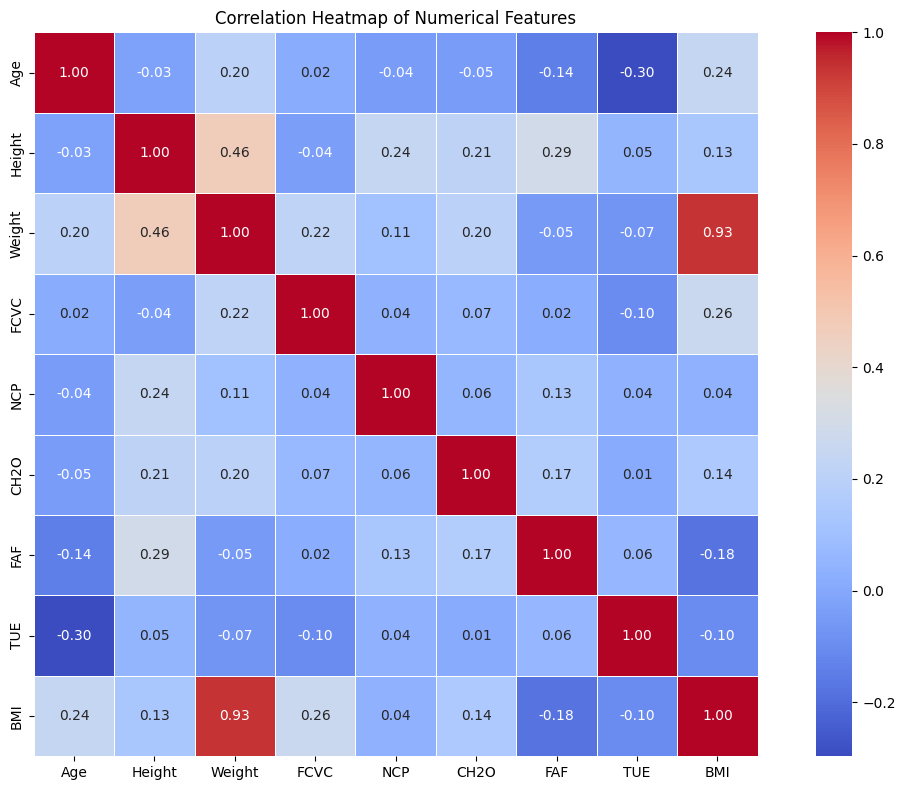

In [24]:

# Correct definition of column names
num_cols = ['Age', 'Height', 'Weight','FCVC', 'NCP','CH2O', 'FAF', 'TUE', 'BMI']

# Compute correlation matrix
corr_matrix = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.savefig("corrheatmap_boxplots.png", dpi=300, bbox_inches='tight')
plt.show()


In [25]:
# List of important features
important_features = [
    'BMI', 'Gender', 'SCC', 'NCP', 'family_history_with_overweight',
    'Weight', 'FAVC', 'Age', 'TUE', 'FCVC', 'Height', 'CAEC'
]

# Display unique values (levels) for each feature
for feature in important_features:
    print(f"\nFeature: {feature}")
    print("Unique values:", df[feature].unique())


Feature: BMI
Unique values: [24.38652644 24.23822715 23.7654321  ... 43.54381658 44.0715354
 44.14433794]

Feature: Gender
Unique values: ['Female' 'Male']

Feature: SCC
Unique values: ['no' 'yes']

Feature: NCP
Unique values: [3.       1.       4.       3.28926  3.995147 1.72626  2.581015 1.600812
 1.73762  1.10548  2.0846   1.894384 2.857787 3.765526 3.285167 3.691226
 3.156153 1.07976  3.559841 3.891994 3.240578 3.904858 3.11158  3.590039
 2.057935 3.558637 2.000986 3.821168 3.897078 3.092116 3.286431 3.592415
 3.754599 3.566082 3.725797 3.520555 3.731212 1.259803 1.273128 3.304123
 3.647154 3.300666 3.535016 1.717608 2.884479 3.626815 1.473088 3.16645
 3.494849 2.99321  2.127797 3.90779  3.699594 3.179995 1.075553 3.238258
 3.804944 1.630846 3.762778 3.371832 2.705445 3.34175  2.217651 2.893778
 3.502604 3.998766 3.193671 1.69608  2.812377 1.612747 1.082304 1.882158
 2.326233 1.989398 1.735493 2.974568 3.715118 3.489918 3.378859 3.263201
 3.994588 3.24934  3.087544 1.163666 3.4093

**Scaling the numerical features**

In [26]:
num_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']
scaler = MinMaxScaler()

    
df[num_cols] = scaler.fit_transform(df[num_cols])

**Label Encoding the Categorical features**

In [27]:
 #Define the categorical columns
cat_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 
            'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

# Initialize LabelEncoder
label_encoder = LabelEncoder()
target_label_encoder = LabelEncoder()  # For target variable
# Apply label encoding to each categorical feature (except for the target column)
for col in cat_cols[:-1]:  # Exclude 'NObeyesdad' column from feature encoding
    df[col] = label_encoder.fit_transform(df[col])

# Target variable (NObeyesdad)
y = df['NObeyesdad']

# Label encode the target variable
y_encoded_labels = target_label_encoder.fit_transform(y)

# One-hot encode the target variable
y_encoded = to_categorical(y_encoded_labels)

# Features (excluding the target column 'NObeyesdad')
X = df.drop('NObeyesdad', axis=1)

# Save the LabelEncoder for the features
joblib.dump(label_encoder, 'label_encoder.pkl')  # Saves the encoder for categorical features

# Save the LabelEncoder for the target variable (NObeyesdad)
joblib.dump(target_label_encoder, 'target_label_encoder.pkl')  # Saves the encoder for the target

# Save the MinMaxScaler (if applicable)
joblib.dump(scaler, 'scaler.pkl')  # Saves the scaler for numerical features
# Check the results
print("One-hot encoded target:")
print(y_encoded[:5])  # Display first 5 rows of the one-hot encoded target

print("\nFeatures (X):")
print(X.head())

One-hot encoded target:
[[0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]

Features (X):
   Gender       Age    Height    Weight  family_history_with_overweight  FAVC  \
0       0  0.148936  0.320755  0.186567                               1     0   
1       0  0.148936  0.132075  0.126866                               1     0   
2       1  0.191489  0.660377  0.283582                               1     0   
3       1  0.276596  0.660377  0.358209                               0     0   
4       1  0.170213  0.622642  0.379104                               0     0   

   FCVC       NCP  CAEC  SMOKE  CH2O  SCC       FAF  TUE  CALC  MTRANS  \
0   0.5  0.666667     2      0   0.5    0  0.000000  0.5     3       3   
1   1.0  0.666667     2      1   1.0    1  1.000000  0.0     2       3   
2   0.5  0.666667     2      0   0.5    0  0.666667  0.5     1       3   
3   1.0  0.666667     2      0   0.5    0  0.666667  0.0 

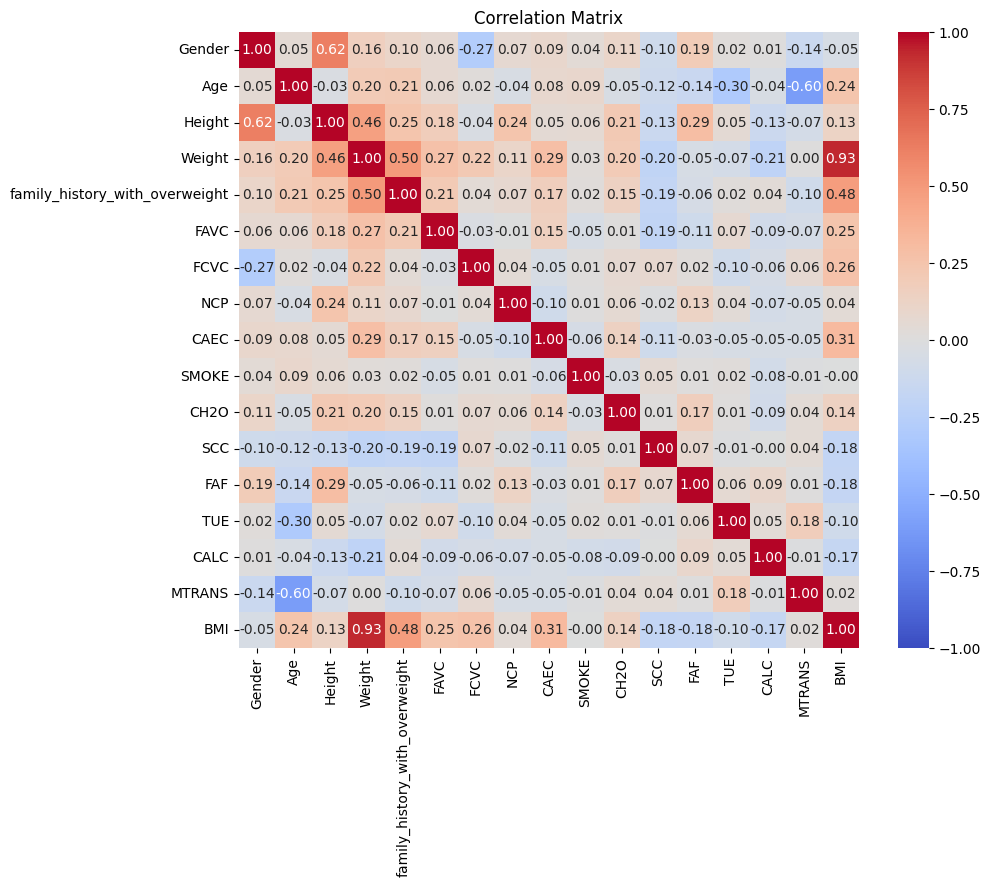

In [28]:
# Select only numeric columns for correlation matrix
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr = df[numeric_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [29]:

# Apply PCA to the full scaled dataset
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X)  # X = df.drop('NObeyesdad', axis=1)

# Optional: Save the PCA transformer
import joblib
joblib.dump(pca, 'pca.pkl')

# Check how much reduction occurred
print(f"Original shape: {X.shape}")
print(f"PCA-reduced shape: {X_pca.shape}")


Original shape: (2111, 17)
PCA-reduced shape: (2111, 11)


In [30]:
# pca.components_ is a matrix of shape (n_components, n_features)
loadings = pd.DataFrame(
    data=pca.components_, 
    columns=X.columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)

print(loadings.head())  # First few PCs


       Gender       Age    Height    Weight  family_history_with_overweight  \
PC1 -0.065420 -0.064771 -0.013013 -0.001648                       -0.035886   
PC2  0.541319  0.016942  0.180185  0.211399                        0.296326   
PC3  0.559206 -0.026179  0.095101 -0.038412                        0.076457   
PC4 -0.505111  0.035783 -0.115852  0.106234                        0.315904   
PC5 -0.067663  0.035987  0.098378  0.201631                        0.671966   

         FAVC      FCVC       NCP      CAEC     SMOKE      CH2O       SCC  \
PC1 -0.020024  0.015485 -0.011548 -0.022948 -0.001315  0.009793  0.008502   
PC2  0.187213 -0.050990  0.034370  0.500507  0.007764  0.179239 -0.080096   
PC3 -0.036879 -0.138583 -0.004492  0.004533 -0.011248  0.007035 -0.025415   
PC4  0.121594  0.099060 -0.087563  0.598697 -0.030705  0.026649 -0.050165   
PC5  0.204446  0.152445  0.144889 -0.586533  0.015157  0.064761 -0.078330   

          FAF       TUE      CALC    MTRANS       BMI  
PC1  0

**Feature Importance Using XG boost**

Feature Importance for each covariate:
                           Feature  Importance
16                             BMI    0.474770
0                           Gender    0.344389
11                             SCC    0.024654
7                              NCP    0.020228
4   family_history_with_overweight    0.015373
3                           Weight    0.014793
5                             FAVC    0.014353
1                              Age    0.013650
13                             TUE    0.012039
6                             FCVC    0.011994
2                           Height    0.011459
8                             CAEC    0.010167
15                          MTRANS    0.009322
12                             FAF    0.009271
10                            CH2O    0.008121
14                            CALC    0.005415
9                            SMOKE    0.000000


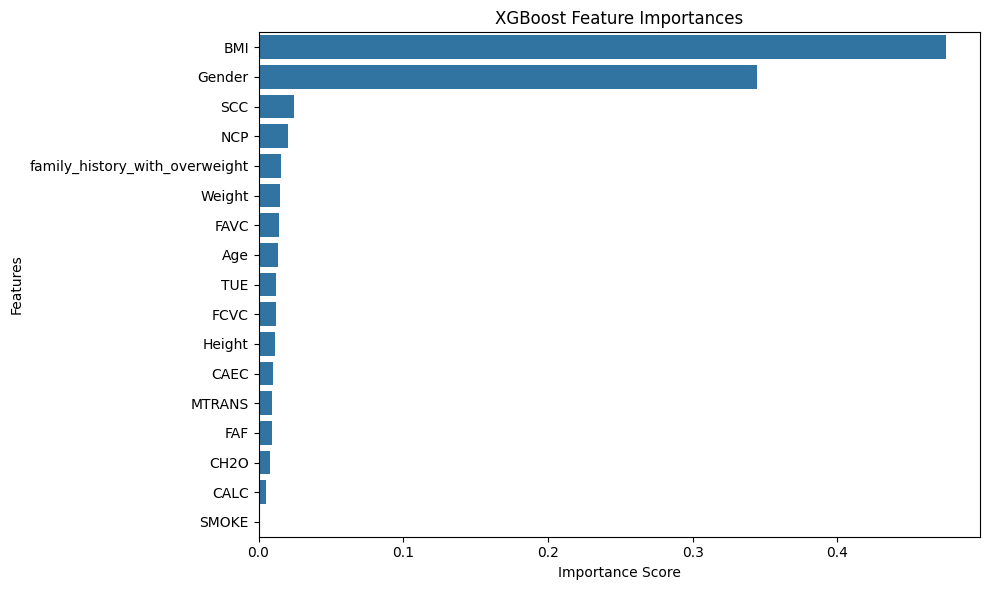

In [31]:
# Train an XGBoost model
modelxgb = xgb.XGBClassifier(eval_metric='mlogloss')
modelxgb.fit(X, y_encoded_labels)

# Get feature importance scores
importances = modelxgb.feature_importances_

# Create a DataFrame with features and their corresponding importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importance for each covariate:")
print(feature_importance_df)
 #Set plot size and style
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)

# Add titles and labels
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')

# Show the plot
plt.tight_layout()
plt.savefig("featureimportance_boxplots.png", dpi=300, bbox_inches='tight')
plt.show()

We used a threshold of 10% and only picked features which met the threshold which were 12 

In [32]:
 #Set your importance threshold
threshold = 0.01

# Filter features above the threshold
important_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature'].tolist()

# Select only those columns from X
X_selected = X[important_features]
print(important_features)

['BMI', 'Gender', 'SCC', 'NCP', 'family_history_with_overweight', 'Weight', 'FAVC', 'Age', 'TUE', 'FCVC', 'Height', 'CAEC']


In [33]:
# Display unique values (levels) for each feature
for feature in important_features:
    print(f"\nFeature: {feature}")
    print("Unique values:", df[feature].unique())


Feature: BMI
Unique values: [0.30116153 0.29723963 0.28473615 ... 0.807793   0.82174899 0.82367432]

Feature: Gender
Unique values: [0 1]

Feature: SCC
Unique values: [0 1]

Feature: NCP
Unique values: [6.66666667e-01 0.00000000e+00 1.00000000e+00 7.63086667e-01
 9.98382333e-01 2.42086667e-01 5.27005000e-01 2.00270667e-01
 2.45873333e-01 3.51600000e-02 3.61533333e-01 2.98128000e-01
 6.19262333e-01 9.21842000e-01 7.61722333e-01 8.97075333e-01
 7.18717667e-01 2.65866667e-02 8.53280333e-01 9.63998000e-01
 7.46859333e-01 9.68286000e-01 7.03860000e-01 8.63346333e-01
 3.52645000e-01 8.52879000e-01 3.33662000e-01 9.40389333e-01
 9.65692667e-01 6.97372000e-01 7.62143667e-01 8.64138333e-01
 9.18199667e-01 8.55360667e-01 9.08599000e-01 8.40185000e-01
 9.10404000e-01 8.66010000e-02 9.10426667e-02 7.68041000e-01
 8.82384667e-01 7.66888667e-01 8.45005333e-01 2.39202667e-01
 6.28159667e-01 8.75605000e-01 1.57696000e-01 7.22150000e-01
 8.31616333e-01 6.64403333e-01 3.75932333e-01 9.69263333e-01
 8.9

**Splitting the data into training and testing**

In [34]:
X_train,X_test,y_train,y_test=train_test_split(X_selected,y_encoded,test_size=0.2,random_state=42)

In [35]:
X_selected.dtypes


BMI                               float64
Gender                              int64
SCC                                 int64
NCP                               float64
family_history_with_overweight      int64
Weight                            float64
FAVC                                int64
Age                               float64
TUE                               float64
FCVC                              float64
Height                            float64
CAEC                                int64
dtype: object

**Building the ANN Model-Deep Learning**

In [36]:

modelann = Sequential()

# Input layer and hidden layers
modelann.add(Input(shape=(X_train.shape[1],)))
modelann.add(Dense(64, activation='relu'))  # First hidden layer
modelann.add(Dropout(0.2))  # Dropout to prevent overfitting
modelann.add(Dense(128, activation='relu'))  # Second hidden layer
modelann.add(Dropout(0.2))

# Output layer with 'softmax' activation for multi-class classification
modelann.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Experiment with different learning rates
modelann.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
modelann.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,055 (39.28 KB)

 Trainable params: 10,055 (39.28 KB)

 Non-trainable params: 0 (0.00 B)

**Training the model**

In [55]:
#Train the model
history = modelann.fit(X_train,y_train,epochs=50,batch_size=32,validation_data=(X_test,y_test))
#Evaluate the model on the test data
loss,accuracy = modelann.evaluate(X_test,y_test)
#print the accuracy
print(f'Accuracy on the test data: {accuracy*100:.2f}%')

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9866 - loss: 0.0508 - val_accuracy: 0.9740 - val_loss: 0.0791
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9878 - loss: 0.0369 - val_accuracy: 0.9693 - val_loss: 0.0723
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9815 - loss: 0.0607 - val_accuracy: 0.9693 - val_loss: 0.0832
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9847 - loss: 0.0588 - val_accuracy: 0.9740 - val_loss: 0.0787
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9829 - loss: 0.0502 - val_accuracy: 0.9764 - val_loss: 0.0825
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9848 - loss: 0.0615 - val_accuracy: 0.9740 - val_loss: 0.0859
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9842 - loss: 0.0411 - val_accuracy: 0.9693 - val_loss: 0.0733
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9806 - loss: 0.0605 - val_accuracy: 0.9787 - val_loss:

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


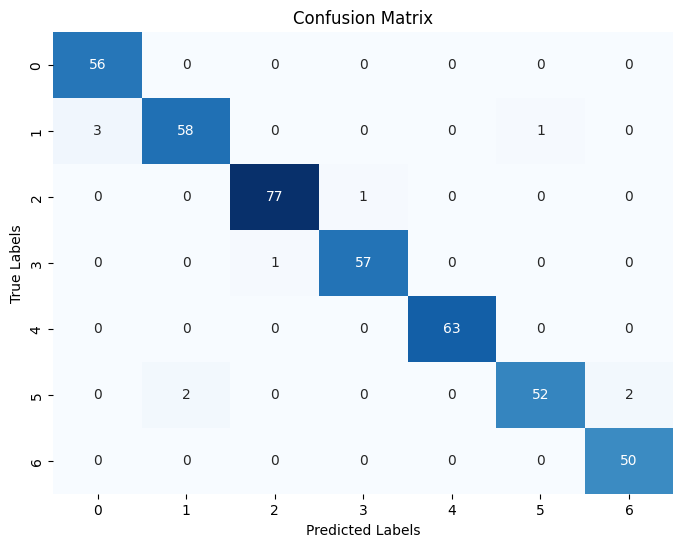

In [56]:
# Predict class probabilities on the test data
y_pred_probabilities = modelann.predict(X_test)

# Convert probabilities to class labels (index of highest probability)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)  # Use np.argmax on y_test to get true class labels

# Create a DataFrame for better visualization of the confusion matrix
class_labels = [0, 1, 2, 3, 4, 5, 6]  # Update with your actual class labels if necessary
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

**Evaluation Metrics**

In [57]:
#make predictions
y_pred = modelann.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test, axis=1)

#Calculate precision, recall and f1 score
precision = precision_score(y_true,y_pred_classes, average = 'weighted')
recall = recall_score(y_true, y_pred_classes, average = 'weighted')
f1 = f1_score(y_true, y_pred_classes, average = 'weighted')

print(f"precision:{precision}")
print(f"recall:{recall}")
print(f"f1 score :{f1}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
precision:0.9766103900935055
recall:0.9763593380614657
f1 score :0.976219268582982


In [58]:
# Save the model in the .keras format
modelann.save('my_model.keras')


In [59]:
# Load the saved model
model = load_model('my_model.keras', compile =False)


In [42]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

def create_model(learning_rate=0.001, dropout_rate=0.2, first_neuron=64, second_neuron=128):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(first_neuron, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(second_neuron, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [43]:
model = KerasClassifier(model=create_model, verbose=0, epochs=50, batch_size=32)


In [44]:
param_grid = {
    'model__learning_rate': [0.001, 0.01],
    'model__dropout_rate': [0.2, 0.3],
    'model__first_neuron': [64, 128],
    'model__second_neuron': [128, 256],
    'batch_size': [32, 64],
    'epochs': [30]  # Keep epochs small to reduce time, then retrain best model fully
}


In [45]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2


You can safely remove it manually.


  Using cached scikit_learn-1.5.2-cp312-cp312-win_amd64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp312-cp312-win_amd64.whl (11.0 MB)


In [46]:
# from sklearn.model_selection import GridSearchCV

# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)
# grid_result = grid.fit(X_train, y_train)


In [47]:
# print(f"Best Accuracy: {grid_result.best_score_:.2f}")
# print("Best Hyperparameters:", grid_result.best_params_)


In [48]:
# best_model = grid_result.best_estimator_
# test_accuracy = best_model.score(X_test, y_test)
# print(f"Test accuracy of the best model: {test_accuracy * 100:.2f}%")


In [61]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

# Load the saved model and necessary components
modelann = load_model('my_model.keras', compile=False)
scaler = joblib.load('scaler.pkl')
target_label_encoder = joblib.load('target_label_encoder.pkl')

# Define recommendations dictionary
recommendations = {
    'Insufficient_Weight': "Increase calorie intake by focusing on nutrient-dense foods like lean proteins, whole grains, and healthy fats. Consult a healthcare provider or nutritionist for personalized advice.",
    'Normal_Weight': "Maintain a balanced diet rich in fruits, vegetables, lean proteins, and whole grains. Engage in regular physical activity for at least 150 minutes per week.",
    'Overweight_Level_I': "Adopt a sustainable calorie deficit by reducing portion sizes and increasing physical activity, such as daily walking or moderate-intensity exercise.",
    'Overweight_Level_II': "Create a personalized weight management plan that includes a calorie-controlled diet, regular exercise (e.g., cardio and strength training), and tracking progress.",
    'Obesity_Type_I': "Consult a healthcare provider for a tailored obesity management plan, which may include dietary changes, exercise routines, and possible medications or therapy.",
    'Obesity_Type_II': "Start a medically supervised weight-loss program that includes a combination of behavioral therapy, dietary changes, exercise, and possibly medications.",
    'Obesity_Type_III': "Consider intensive weight-loss interventions, such as bariatric surgery, medication, or a combination of these options, under the guidance of a healthcare professional."
}

# Important features identified through feature selection
important_features = ['BMI', 'Gender', 'SCC', 'NCP', 'family_history_with_overweight', 
                      'Weight', 'FAVC', 'Age', 'TUE', 'FCVC', 'Height', 'CAEC']

# Features that were originally scaled (numerical features)
scaled_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']

# Numerical features that are both important AND were scaled
important_scaled_features = [feature for feature in important_features if feature in scaled_features]
print(f"Important features that were scaled: {important_scaled_features}")

# Function to predict using only the necessary features
def predict_and_recommend(user_data, model, scaler):
    """
    Make predictions using only the important scaled features.
    
    Parameters:
    - user_data: DataFrame, Series, or dict with user health metrics
    - model: Loaded Keras model
    - scaler: MinMaxScaler for feature scaling
    
    Returns:
    - predicted_label: Obesity classification
    - recommendation: Health advice based on classification
    """
    # Convert input to DataFrame if needed
    if isinstance(user_data, dict):
        user_data = pd.DataFrame([user_data])
    elif isinstance(user_data, pd.Series):
        user_data = pd.DataFrame([user_data]).reset_index(drop=True)
    
    # Verify we have all important features
    missing_features = [f for f in important_features if f not in user_data.columns]
    if missing_features:
        raise ValueError(f"Missing important features: {missing_features}")
    
    # Extract only the features that need scaling
    scaling_data = user_data[important_scaled_features].copy()
    
    # Create a temporary DataFrame with only the features the scaler expects (in the correct order)
    temp_df = pd.DataFrame(columns=scaled_features)
    temp_df.loc[0] = 0  # Initialize with zeros
    
    # Fill in the values for the important scaled features we have
    for feature in important_scaled_features:
        temp_df[feature] = scaling_data[feature].values[0]
    
    # Scale the data
    scaled_data = scaler.transform(temp_df)
    
    # Extract only the scaled features we need for the model
    # Since the model was trained with important features, we need to:
    # 1. Get indices of important_scaled_features in the scaled_features list
    indices = [scaled_features.index(feature) for feature in important_scaled_features]
    # 2. Extract only those columns from the scaled data
    model_input_scaled = scaled_data[:, indices]
    
    # Create the final input for the model by combining:
    # 1. The scaled numerical features
    # 2. The categorical features (which don't need scaling)
    categorical_features = [f for f in important_features if f not in scaled_features]
    categorical_data = user_data[categorical_features].values
    
    # Combine both into the final model input
    # This assumes your model expects all important features in the same order as important_features
    final_input = np.zeros((1, len(important_features)))
    
    # Fill in the categorical features
    for i, feature in enumerate(categorical_features):
        feature_index = important_features.index(feature)
        final_input[0, feature_index] = categorical_data[0, i]
    
    # Fill in the scaled numerical features
    for i, feature in enumerate(important_scaled_features):
        feature_index = important_features.index(feature)
        final_input[0, feature_index] = model_input_scaled[0, i]
    
    # Make the prediction
    probs = model.predict(final_input)
    class_index = np.argmax(probs, axis=1)[0]
    
    # Get the class name
    predicted_label = target_label_encoder.classes_[class_index]
    
    # Get the recommendation
    recommendation = recommendations.get(predicted_label, "No recommendation available.")
    
    return predicted_label, recommendation

# Example: Using X_selected directly
try:
    # Test with the first row
    new_user = X_selected.iloc[0]
    label, advice = predict_and_recommend(new_user, modelann, scaler)
    
    print(f"\nPredicted Obesity Level: {label}")
    print("Personalized Recommendation:")
    print(advice)
    
except NameError:
    print("X_selected not defined. Try using the example_user dictionary below.")
except Exception as e:
    print(f"Error: {e}")

# Example: Manual input with important features only
example_user = {
    'BMI': 21.6,
    'Gender': 1,  # Encoded value
    'SCC': 0,     # Encoded value
    'NCP': 3,     
    'family_history_with_overweight': 1,  # Encoded value
    'Weight': 70, # kg
    'FAVC': 0,    # Encoded value
    'Age': 25,
    'TUE': 1,     
    'FCVC': 3,    
    'Height': 180, # cm
    'CAEC': 2     # Encoded value
}

# Uncomment to use manual input example
# try:
#     print("\nTrying with manual input example...")
#     label, advice = predict_and_recommend(example_user, modelann, scaler)
#     print(f"Predicted Obesity Level: {label}")
#     print("Personalized Recommendation:")
#     print(advice)
# except Exception as e:
#     print(f"Error with manual input: {e}")

Important features that were scaled: ['BMI', 'NCP', 'Weight', 'Age', 'TUE', 'FCVC', 'Height']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

Predicted Obesity Level: Normal_Weight
Personalized Recommendation:
Maintain a balanced diet rich in fruits, vegetables, lean proteins, and whole grains. Engage in regular physical activity for at least 150 minutes per week.


In [62]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

# Load the saved model and necessary components
modelann = load_model('my_model.keras', compile=False)
scaler = joblib.load('scaler.pkl')
target_label_encoder = joblib.load('target_label_encoder.pkl')

# Define obesity level definitions
obesity_definitions = {
    'Insufficient_Weight': "Underweight condition where BMI is below the normal healthy range. This may indicate malnutrition, eating disorders, or underlying health conditions that require medical attention.",
    'Normal_Weight': "Healthy weight range with BMI between 18.5-24.9. This indicates a balanced relationship between height and weight, associated with lower risk of weight-related health problems.",
    'Overweight_Level_I': "Mild overweight condition with BMI between 25-29.9. This represents excess body weight that may increase the risk of developing health problems like diabetes and heart disease.",
    'Overweight_Level_II': "Moderate overweight condition approaching obesity. This level indicates significant excess weight that substantially increases health risks and requires active intervention.",
    'Obesity_Type_I': "Class I Obesity with BMI between 30-34.9. This is a medical condition characterized by excessive body fat that significantly increases the risk of serious health complications.",
    'Obesity_Type_II': "Class II Obesity with BMI between 35-39.9. This represents severe obesity with very high health risks, including cardiovascular disease, diabetes, and other serious conditions.",
    'Obesity_Type_III': "Class III Obesity (Morbid Obesity) with BMI ≥40. This is the most severe form of obesity, associated with extremely high health risks and often requiring intensive medical intervention."
}

# Define recommendations dictionary
recommendations = {
    'Insufficient_Weight': "Increase calorie intake by focusing on nutrient-dense foods like lean proteins, whole grains, and healthy fats. Consult a healthcare provider or nutritionist for personalized advice.",
    'Normal_Weight': "Maintain a balanced diet rich in fruits, vegetables, lean proteins, and whole grains. Engage in regular physical activity for at least 150 minutes per week.",
    'Overweight_Level_I': "Adopt a sustainable calorie deficit by reducing portion sizes and increasing physical activity, such as daily walking or moderate-intensity exercise.",
    'Overweight_Level_II': "Create a personalized weight management plan that includes a calorie-controlled diet, regular exercise (e.g., cardio and strength training), and tracking progress.",
    'Obesity_Type_I': "Consult a healthcare provider for a tailored obesity management plan, which may include dietary changes, exercise routines, and possible medications or therapy.",
    'Obesity_Type_II': "Start a medically supervised weight-loss program that includes a combination of behavioral therapy, dietary changes, exercise, and possibly medications.",
    'Obesity_Type_III': "Consider intensive weight-loss interventions, such as bariatric surgery, medication, or a combination of these options, under the guidance of a healthcare professional."
}

# Important features identified through feature selection
important_features = ['BMI', 'Gender', 'SCC', 'NCP', 'family_history_with_overweight', 
                      'Weight', 'FAVC', 'Age', 'TUE', 'FCVC', 'Height', 'CAEC']

# Features that were originally scaled (numerical features)
scaled_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']

# Numerical features that are both important AND were scaled
important_scaled_features = [feature for feature in important_features if feature in scaled_features]
print(f"Important features that were scaled: {important_scaled_features}")

# Function to predict using only the necessary features
def predict_and_recommend(user_data, model, scaler):
    """
    Make predictions using only the important scaled features and provide
    definition and recommendation.
    
    Parameters:
    - user_data: DataFrame, Series, or dict with user health metrics
    - model: Loaded Keras model
    - scaler: MinMaxScaler for feature scaling
    
    Returns:
    - predicted_label: Obesity classification
    - definition: Medical definition of the obesity level
    - recommendation: Health advice based on classification
    """
    # Convert input to DataFrame if needed
    if isinstance(user_data, dict):
        user_data = pd.DataFrame([user_data])
    elif isinstance(user_data, pd.Series):
        user_data = pd.DataFrame([user_data]).reset_index(drop=True)
    
    # Verify we have all important features
    missing_features = [f for f in important_features if f not in user_data.columns]
    if missing_features:
        raise ValueError(f"Missing important features: {missing_features}")
    
    # Extract only the features that need scaling
    scaling_data = user_data[important_scaled_features].copy()
    
    # Create a temporary DataFrame with only the features the scaler expects (in the correct order)
    temp_df = pd.DataFrame(columns=scaled_features)
    temp_df.loc[0] = 0  # Initialize with zeros
    
    # Fill in the values for the important scaled features we have
    for feature in important_scaled_features:
        temp_df[feature] = scaling_data[feature].values[0]
    
    # Scale the data
    scaled_data = scaler.transform(temp_df)
    
    # Extract only the scaled features we need for the model
    # Since the model was trained with important features, we need to:
    # 1. Get indices of important_scaled_features in the scaled_features list
    indices = [scaled_features.index(feature) for feature in important_scaled_features]
    # 2. Extract only those columns from the scaled data
    model_input_scaled = scaled_data[:, indices]
    
    # Create the final input for the model by combining:
    # 1. The scaled numerical features
    # 2. The categorical features (which don't need scaling)
    categorical_features = [f for f in important_features if f not in scaled_features]
    categorical_data = user_data[categorical_features].values
    
    # Combine both into the final model input
    # This assumes your model expects all important features in the same order as important_features
    final_input = np.zeros((1, len(important_features)))
    
    # Fill in the categorical features
    for i, feature in enumerate(categorical_features):
        feature_index = important_features.index(feature)
        final_input[0, feature_index] = categorical_data[0, i]
    
    # Fill in the scaled numerical features
    for i, feature in enumerate(important_scaled_features):
        feature_index = important_features.index(feature)
        final_input[0, feature_index] = model_input_scaled[0, i]
    
    # Make the prediction
    probs = model.predict(final_input)
    class_index = np.argmax(probs, axis=1)[0]
    
    # Get the class name
    predicted_label = target_label_encoder.classes_[class_index]
    
    # Get the definition and recommendation
    definition = obesity_definitions.get(predicted_label, "No definition available.")
    recommendation = recommendations.get(predicted_label, "No recommendation available.")
    
    return predicted_label, definition, recommendation

# Enhanced display function
def display_results(predicted_label, definition, recommendation):
    """
    Display the results in a formatted way
    """
    print("=" * 70)
    print(f"OBESITY LEVEL PREDICTION: {predicted_label.replace('_', ' ').title()}")
    print("=" * 70)
    
    print("\n📋 DEFINITION:")
    print("-" * 50)
    print(f"{definition}")
    
    print("\n💡 PERSONALIZED RECOMMENDATION:")
    print("-" * 50)
    print(f"{recommendation}")
    print("=" * 70)

# Example: Using X_selected directly
try:
    # Test with the first row
    new_user = X_selected.iloc[0]
    label, definition, advice = predict_and_recommend(new_user, modelann, scaler)
    
    display_results(label, definition, advice)
    
except NameError:
    print("X_selected not defined. Try using the example_user dictionary below.")
except Exception as e:
    print(f"Error: {e}")

# Example: Manual input with important features only
example_user = {
    'BMI': 21.6,
    'Gender': 1,  # Encoded value
    'SCC': 0,     # Encoded value
    'NCP': 3,     
    'family_history_with_overweight': 1,  # Encoded value
    'Weight': 70, # kg
    'FAVC': 0,    # Encoded value
    'Age': 25,
    'TUE': 1,     
    'FCVC': 3,    
    'Height': 180, # cm
    'CAEC': 2     # Encoded value
}

# Uncomment to use manual input example
print("\nTrying with manual input example...")
try:
    label, definition, advice = predict_and_recommend(example_user, modelann, scaler)
    display_results(label, definition, advice)
except Exception as e:
    print(f"Error with manual input: {e}")

# Function to get just the definition of any obesity level
def get_obesity_definition(obesity_level):
    """
    Get the definition of a specific obesity level
    
    Parameters:
    - obesity_level: String representing the obesity classification
    
    Returns:
    - definition: Medical definition of the obesity level
    """
    return obesity_definitions.get(obesity_level, "Obesity level not recognized.")

# Example of getting definitions for all levels
print("\n📚 ALL OBESITY LEVEL DEFINITIONS:")
print("=" * 70)
for level, definition in obesity_definitions.items():
    print(f"\n{level.replace('_', ' ').title()}:")
    print(f"{definition}")
    print("-" * 50)

Important features that were scaled: ['BMI', 'NCP', 'Weight', 'Age', 'TUE', 'FCVC', 'Height']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
OBESITY LEVEL PREDICTION: Normal Weight

📋 DEFINITION:
--------------------------------------------------
Healthy weight range with BMI between 18.5-24.9. This indicates a balanced relationship between height and weight, associated with lower risk of weight-related health problems.

💡 PERSONALIZED RECOMMENDATION:
--------------------------------------------------
Maintain a balanced diet rich in fruits, vegetables, lean proteins, and whole grains. Engage in regular physical activity for at least 150 minutes per week.

Trying with manual input example...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
OBESITY LEVEL PREDICTION: Normal Weight

📋 DEFINITION:
--------------------------------------------------
Healthy weight range with BMI between 18.5-24.9. This indicates a balanced relationship between height and weight, associated with lower risk of weight-related heal

In [ ]:
**#Using Supervised Learning**

**1.Using Decision Trees**

In [64]:
# Train the model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = model.score(X_test, y_test)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print results
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'F1 Score: {f1*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')


Accuracy: 96.45%
F1 Score: 96.46%
Precision: 96.64%
Recall: 96.45%


**2.Using Random forest**

In [65]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# 1. Convert one-hot encoded targets to integer labels
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# 2. Initialize XGBoost model
model = XGBClassifier(random_state=42, eval_metric='mlogloss')  # 'mlogloss' for multiclass

# 3. Fit the model
model.fit(X_train, y_train_labels)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Calculate performance metrics
accuracy = accuracy_score(y_test_labels, y_pred)
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')

# 6. Print results
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

# 7. Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_test_labels, y_pred))


Accuracy: 98.58%
Precision: 98.65%
Recall: 98.58%
F1 Score: 98.58%

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        56
           1       0.94      1.00      0.97        62
           2       1.00      0.99      0.99        78
           3       0.98      1.00      0.99        58
           4       1.00      1.00      1.00        63
           5       1.00      0.95      0.97        56
           6       0.98      1.00      0.99        50

    accuracy                           0.99       423
   macro avg       0.99      0.99      0.99       423
weighted avg       0.99      0.99      0.99       423



In [67]:
# 8. Predict on the test set
y_pred = best_model.predict(X_test)

# 9. Calculate performance metrics
accuracy = accuracy_score(y_test_labels, y_pred)
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')

# 10. Print results
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

# 11. Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_test_labels, y_pred))


Accuracy: 98.58%
Precision: 98.64%
Recall: 98.58%
F1 Score: 98.58%

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        56
           1       0.95      1.00      0.98        62
           2       1.00      0.99      0.99        78
           3       0.98      1.00      0.99        58
           4       1.00      1.00      1.00        63
           5       1.00      0.95      0.97        56
           6       0.96      1.00      0.98        50

    accuracy                           0.99       423
   macro avg       0.99      0.99      0.99       423
weighted avg       0.99      0.99      0.99       423



**Using Random Forest**

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# 1. Convert one-hot encoded targets to class labels
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# 2. Initialize and train the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train_labels)

# 3. Predict on test set
y_pred = model.predict(X_test)

# 4. Evaluate model performance
accuracy = accuracy_score(y_test_labels, y_pred)
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')

# 5. Print results
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

# 6. Optional: Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_test_labels, y_pred))


**Using Logistics Regression**

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# 1. Convert one-hot encoded targets to integer labels
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# 2. Initialize and train the logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train_labels)

# 3. Predict on test set
y_pred = model.predict(X_test)

# 4. Evaluate model
accuracy = accuracy_score(y_test_labels, y_pred)
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')

# 5. Print results
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

# 6. Optional: Detailed report
print("\nClassification Report:\n")
print(classification_report(y_test_labels, y_pred))
